## Maven Analytics Coffee Challenge
Leverage the results of The Great American Taste Test to craft a data-driven strategy for opening a coffee business in the U.S.  
  
For the **Maven Coffee Challenge**, you'll play the role of an Analytics Consultant hired by a group of investors looking to break into the US coffee market. They would like to leverage insights from "The Great American Coffee Taste Test", but lack the analytical skills to do so. That's where you come in!

You've been asked to share an **explanatory report providing a data-driven strategy for opening their first coffee shop**. The investors expressed interest in the following areas, but are open to any additional insights and recommendations you can provide:

- **Target audience**: What type of customer should we target, and what are their preferences?
- **Product offering**: What types of coffee beans and drinks should we offer?
- **Pricing strategy**: How can we align prices with customer value perception?

### Import necessary libraries

In [1]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

### Import and inspect dataset

In [2]:
# Import GACTT_RESULTS_ANAHYMIZED_v2.csv as 'data' dataframe
data = pd.read_csv('GACTT_RESULTS_ANONYMIZED_v2.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4042 entries, 0 to 4041
Columns: 111 entries, Submission ID to Political Affiliation
dtypes: float64(21), object(90)
memory usage: 3.4+ MB


## Target Audience
What type of customer should we target, and what are their preferences?

We'll use K-Means clustering to find which segments are most profitable to target, and then look into the demographic and behavioral trends of those resulting segments. We'll use the following four questions for clustering:
- How many cups of coffee do you typically drink per day?
- In total, how much money do you typically spend on coffee in a month?
- What is the most you've ever paid for a cup of coffee?
- What is the most you'd ever be willing to pay for a cup of coffee?

### Set up values for clustering

In [4]:
# Select the columns that correspond to the questions we want to use for segmenting our respondents
for_clustering = pd.DataFrame(data[["How many cups of coffee do you typically drink per day?",
                                    "In total, much money do you typically spend on coffee in a month?",
                                    "What is the most you've ever paid for a cup of coffee?",
                                    "What is the most you'd ever be willing to pay for a cup of coffee?"]])

In [5]:
# Use .info() to inspect the data in this smaller table
for_clustering.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4042 entries, 0 to 4041
Data columns (total 4 columns):
 #   Column                                                              Non-Null Count  Dtype 
---  ------                                                              --------------  ----- 
 0   How many cups of coffee do you typically drink per day?             3949 non-null   object
 1   In total, much money do you typically spend on coffee in a month?   3511 non-null   object
 2   What is the most you've ever paid for a cup of coffee?              3527 non-null   object
 3   What is the most you'd ever be willing to pay for a cup of coffee?  3510 non-null   object
dtypes: object(4)
memory usage: 126.4+ KB


In [6]:
# All of these questions have value ranges rather than numerical responses, so we'll use the midpoints of each range for clustering
# Map for the most they've paid for & would be willing to pay for a cup of coffee
cup_price_map = {
    "Less than $2": 1,
    "$2-$4": 3,
    "$4-$6": 5,
    "$6-$8": 7,
    "$8-$10": 9,
    "$10-$15": 13.5,
    "$15-$20": 17.5,
    "More than $20": 22
}

# Map for how much they typicall spend on coffee per month
monthly_spend_map = {
    "<$20": 10,
    "$20-$40": 30,
    "$40-$60": 50,
    "$60-$80": 70,
    "$80-$100": 90,
    ">$100": 110,
}

# Map for how many cups of coffee they typically drink per day
num_cups_daily = {
    "Less than 1": 0.5,
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "More than 4": 5,
}

In [7]:
# Use the maps created above to create new columns with answers mapped to single values rather than value ranges
for_clustering["Most paid for a cup"] = for_clustering["What is the most you've ever paid for a cup of coffee?"].map(cup_price_map)
for_clustering["Most would pay for a cup"] = for_clustering["What is the most you'd ever be willing to pay for a cup of coffee?"].map(cup_price_map)
for_clustering["Typical monthly spend"] = for_clustering["In total, much money do you typically spend on coffee in a month?"].map(monthly_spend_map)
for_clustering["Cups per day"] = for_clustering["How many cups of coffee do you typically drink per day?"].map(num_cups_daily)

In [8]:
# We have a large enough share of data that are nulls, so we'll use the median values to fill them in

# Find the median values of each column
display(for_clustering["Most paid for a cup"].median())
display(for_clustering["Most would pay for a cup"].median())
display(for_clustering["Typical monthly spend"].median())
display(for_clustering["Cups per day"].median())

9.0

9.0

50.0

2.0

In [9]:
# Fill in the null values of each column with the medians
for_clustering["Most paid for a cup"].fillna(9, inplace = True)
for_clustering["Most would pay for a cup"].fillna(9, inplace = True)
for_clustering["Typical monthly spend"].fillna(50, inplace = True)
for_clustering["Cups per day"].fillna(2, inplace = True)

### Create clusters

In [10]:
# Pull all of our columns from the for_clustering table that have our mapped single values & nulls filled in
cluster_creation = pd.DataFrame(for_clustering[["Most paid for a cup",
                                                "Most would pay for a cup",
                                                "Typical monthly spend",
                                                "Cups per day"]])

In [11]:
# Normalize the data in the cluster_creation dataframe (to achieve zero mean and unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_creation)

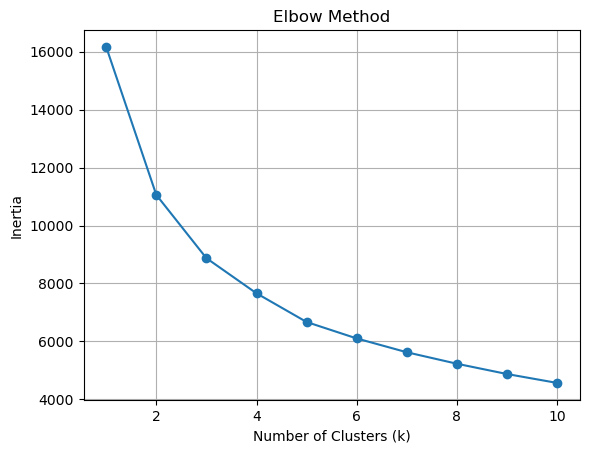

In [12]:
# Calculate how well the data fits into different numbers of clusters and use an elbow graph to determine what number of k clusters is best
sse = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

# Plot the elbow graph
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

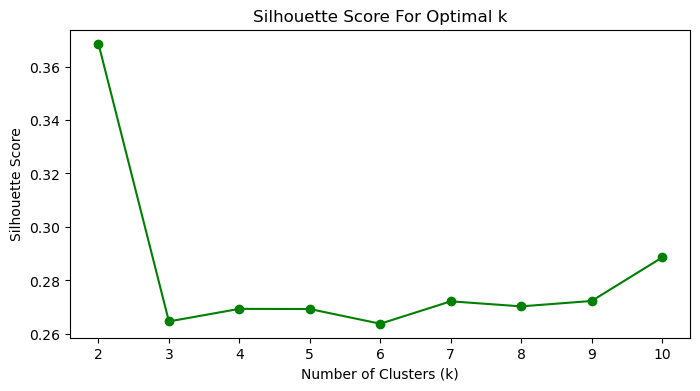

In [13]:
# It's not very obvious from the elbow graph which number of clusters would be best, so we'll use silhouette scores to help decide

# Calculate the silhouette score for different numbers of k clusters and plot the scores to determine what number of clusters is best
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(K, silhouette_scores, 'go-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.xticks(K)
plt.show()

### Segment data by clusters

In [14]:
# Create final clusters using the best number

# Even though the silhouette score was highest for 2 clusters, I chose 3 clusters because they provided more meaningful and unique groupings.
# This trade-off gave slightly lower scores but better insights from the data.
best_k = 3

# Add cluster labels to our data so we can see which rows belong in which group
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init = 10)
cluster_creation['cluster'] = kmeans.fit_predict(X_scaled)


In [15]:
# Look at the mean values for each cluster to assess the differences between each
cluster_creation.groupby('cluster')[["Most paid for a cup", "Most would pay for a cup", "Typical monthly spend", "Cups per day"]].mean().round(2)

,Most paid for a cup,Most would pay for a cup,Typical monthly spend,Cups per day
cluster,,,,
0,8.21,9.19,57.06,2.41
1,7.62,9.11,30.06,1.19
2,14.46,19.12,57.70,1.99


In [16]:
# Check the averages for the overall data to see how clusters compare to all respondents
print(for_clustering["Most paid for a cup"].mean())
print(for_clustering["Most would pay for a cup"].mean())
print(for_clustering["Typical monthly spend"].mean())
print(for_clustering["Cups per day"].mean())

9.405616031667492
11.459549727857496
45.44285007422068
1.78154379020287


Some notes on what we can see so far:
- **Cluster 0:** They consumer the highest number of cups perday and the highest monthly spend, even though they've got a more modest price ceiling.
- **Cluster 1:** They're the lowest spenders, both per month and per cup of coffee, and they're drinking the lowest number of cups per day.
- **Cluster 2:** They do and are willing to pay the most per cup of coffee, although their consumption per day is lower so their typical monthly spend matches that of cluster 0.

It looks like it would be best to target Cluster 0 and 2 based on their spending and consumption habits.

### Add cluster labels to original data
We'll add the cluster labels into our original dataframe (data) so that we can look at demographic and behavioral trends.

In [17]:
# Add out "Cluster" column with our k cluster labels to the data dataframe
clustered = data.join(pd.Series(kmeans.labels_, name="Cluster"))

In [18]:
# Separate our clusters into their own dataframes
cluster_0 = clustered[clustered["Cluster"] == 0].copy()
cluster_1 = clustered[clustered["Cluster"] == 1].copy()
cluster_2 = clustered[clustered["Cluster"] == 2].copy()

### Define Function for Cluster Trend Analysis

In [19]:
# Create a function that will help us look at demographics and coffee preference trends for each cluster
def cluster_trends(dataframe):
    # --- Demographics ---
    print(round(((dataframe["What is your age?"].value_counts())/len(dataframe))*100, 1))
    print("")
    print(round(((dataframe["Ethnicity/Race"].value_counts())/len(dataframe))*100, 1))
    print("")
    print(round(((dataframe["Gender"].value_counts())/len(dataframe))*100, 1))
    print("")
    print(round(((dataframe["Education Level"].value_counts())/len(dataframe))*100, 1))
    print("")
    print(round(((dataframe["Employment Status"].value_counts())/len(dataframe))*100, 1))
    print("")
    print(round(((dataframe["Political Affiliation"].value_counts())/len(dataframe))*100, 1))
    print("")
    print(round(((dataframe["Number of Children"].value_counts())/len(dataframe))*100, 1))
    print("")
    print(round(((dataframe["Lastly, how would you rate your own coffee expertise?"].value_counts())/len(dataframe))*100, 1))
    print("")
    # --- Work Habits ---
    print(round(((dataframe["Do you work from home or in person?"].value_counts())/len(dataframe))*100, 1))
    print("")
    # --- Coffee Drinking/Purchasing Habits ---
    print("Where do you typically drink coffee?")
    print(f"At home: {round(((len(dataframe[dataframe['Where do you typically drink coffee? (At home)'] == True])/len(dataframe)))*100, 1)}")
    print(f"At the office: {round(((len(dataframe[dataframe['Where do you typically drink coffee? (At the office)'] == True])/len(dataframe)))*100, 1)}")
    print(f"At a cafe: {round(((len(dataframe[dataframe['Where do you typically drink coffee? (At a cafe)'] == True])/len(dataframe)))*100, 1)}")
    print(f"On the go: {round(((len(dataframe[dataframe['Where do you typically drink coffee? (On the go)'] == True])/len(dataframe)))*100, 1)}")
    print(f"None of these: {round(((len(dataframe[dataframe['Where do you typically drink coffee? (None of these)'] == True])/len(dataframe)))*100, 1)}")
    print("")
    print("On the go, where do you typically purchase coffee?")
    print(f"Naitonal chain: {round(((len(dataframe[dataframe['On the go, where do you typically purchase coffee? (National chain (e.g. Starbucks, Dunkin))'] == True])/len(dataframe)))*100, 1)}")
    print(f"Local cafe: {round(((len(dataframe[dataframe['On the go, where do you typically purchase coffee? (Local cafe)'] == True])/len(dataframe)))*100, 1)}")
    print(f"Drive-thru: {round(((len(dataframe[dataframe['On the go, where do you typically purchase coffee? (Drive-thru)'] == True])/len(dataframe)))*100, 1)}")
    print(f"Specialty coffee shop: {round(((len(dataframe[dataframe['On the go, where do you typically purchase coffee? (Specialty coffee shop)'] == True])/len(dataframe)))*100, 1)}")
    print(f"Deli or supermarket: {round(((len(dataframe[dataframe['On the go, where do you typically purchase coffee? (Deli or supermarket)'] == True])/len(dataframe)))*100, 1)}")
    print(f"Other: {round(((len(dataframe[dataframe['On the go, where do you typically purchase coffee? (Other)'] == True])/len(dataframe)))*100, 1)}")
    print("")
    print(round(((dataframe["Do you feel like you’re getting good value for your money when you buy coffee at a cafe?"].value_counts())/len(dataframe))*100, 1))
    print("")
    print("Why do you drink coffee?")
    print(f"I need the caffeine: {round(((len(dataframe[dataframe['Why do you drink coffee? (I need the caffeine)'] == True])/len(dataframe)))*100, 1)}")
    print(f"I need the ritual: {round(((len(dataframe[dataframe['Why do you drink coffee? (I need the ritual)'] == True])/len(dataframe)))*100, 1)}")
    print(f"It makes me go to the bathroom: {round(((len(dataframe[dataframe['Why do you drink coffee? (It makes me go to the bathroom)'] == True])/len(dataframe)))*100, 1)}")
    print(f"It tastes good: {round(((len(dataframe[dataframe['Why do you drink coffee? (It tastes good)'] == True])/len(dataframe)))*100, 1)}")
    print(f"Other: {round(((len(dataframe[dataframe['Why do you drink coffee? (Other)'] == True])/len(dataframe)))*100, 1)}")
    print("")
    # --- Coffee Taste Preferences ---
    print(round(((dataframe["Between Coffee A, Coffee B, and Coffee C which did you prefer?"].value_counts())/len(dataframe))*100, 1))
    print("")
    print(round(((dataframe["Between Coffee A and Coffee D, which did you prefer?"].value_counts())/len(dataframe))*100, 1))
    print("")
    print(round(((dataframe["Lastly, what was your favorite overall coffee?"].value_counts())/len(dataframe))*100, 1))
    print("")
    print(round(((dataframe["Before today's tasting, which of the following best described what kind of coffee you like?"].value_counts())/len(dataframe))*100, 1))
    print("")
    print(round(((dataframe["Do you like the taste of coffee?"].value_counts())/len(dataframe))*100, 1))
    print("")
    # --- General Coffee Preferences ---
    print(round(((dataframe["Do you know where your coffee comes from?"].value_counts())/len(dataframe))*100, 1))
    print("")
    print(round(((dataframe["What is your favorite coffee drink?"].value_counts())/len(dataframe))*100, 1))
    print("")
    print("Do you usually add anything to your coffee?")
    print(f"No - just black: {round(((len(dataframe[dataframe['Do you usually add anything to your coffee? (No - just black)'] == True])/len(dataframe)))*100, 1)}")
    print(f"Milk, dairy alternative, or coffee creamer: {round(((len(dataframe[dataframe['Do you usually add anything to your coffee? (Milk, dairy alternative, or coffee creamer)'] == True])/len(dataframe)))*100, 1)}")
    print(f"Sugar or sweetner: {round(((len(dataframe[dataframe['Do you usually add anything to your coffee? (Sugar or sweetener)'] == True])/len(dataframe)))*100, 1)}")
    print(f"Flavor syrup: {round(((len(dataframe[dataframe['Do you usually add anything to your coffee? (Flavor syrup)'] == True])/len(dataframe)))*100, 1)}")
    print(f"Other: {round(((len(dataframe[dataframe['Do you usually add anything to your coffee? (Other)'] == True])/len(dataframe)))*100, 1)}")
    print("")
    print("What kind of dairy do you add?")
    print(f"Whole milk: {round(((len(dataframe[dataframe['What kind of dairy do you add? (Whole milk)'] == True])/len(dataframe)))*100, 1)}")
    print(f"Skim milk: {round(((len(dataframe[dataframe['What kind of dairy do you add? (Skim milk)'] == True])/len(dataframe)))*100, 1)}")
    print(f"Half and half: {round(((len(dataframe[dataframe['What kind of dairy do you add? (Half and half)'] == True])/len(dataframe)))*100, 1)}")
    print(f"Coffee creamer: {round(((len(dataframe[dataframe['What kind of dairy do you add? (Coffee creamer)'] == True])/len(dataframe)))*100, 1)}")
    print(f"Flavored coffee creamer: {round(((len(dataframe[dataframe['What kind of dairy do you add? (Flavored coffee creamer)'] == True])/len(dataframe)))*100, 1)}")
    print(f"Oat milk: {round(((len(dataframe[dataframe['What kind of dairy do you add? (Oat milk)'] == True])/len(dataframe)))*100, 1)}")
    print(f"Almond milk: {round(((len(dataframe[dataframe['What kind of dairy do you add? (Almond milk)'] == True])/len(dataframe)))*100, 1)}")
    print(f"Soy milk: {round(((len(dataframe[dataframe['What kind of dairy do you add? (Soy milk)'] == True])/len(dataframe)))*100, 1)}")
    print("")
    print(round(((dataframe["How strong do you like your coffee?"].value_counts())/len(dataframe))*100, 1))
    print("")
    print(round(((dataframe["What roast level of coffee do you prefer?"].value_counts())/len(dataframe))*100, 1))
    print("")
    print(round(((dataframe["How much caffeine do you like in your coffee?"].value_counts())/len(dataframe))*100, 1))

## Product Offering
What types of coffee beans and drinks should we offer?

### Trends from All Data
We'll look at these trends for all of the data first to find our baseline for what's typical of the respondents for this survey.

Overall, survey respondents have an average age of about 34 years old. They are majority male (62.4%), and 81.6% have at least some college education. Most (72%) are employed, with 54.7% of those employed primarily working from home and 36.1% primarily working in person.

**Coffee Habits**
- 90.2% typically drink coffee at home
- 35.4% typically drink coffee at the office
- 28.9% typically drink coffee at a cafe
- Of the 17.4% who typically drink coffee on the go, local cafes are the second most common place of purchase (after specialty coffee shops).
- 50.7% of respondents say they feel they get good value for their money when they purchase coffee from a cafe.

**Taste Test Results**
- Between Coffees A, B, and C: 41.6% preferred Coffee A
- Between Coffees A and D: 49.9% preferred Coffee D
- Overall, Coffee D was the most common favorite (34.3%), ~14 percentage points higher than Coffee A (the second most common favorite).

**Flavor and Drink Preferences (before taste test)**
- 23.6% prefer fruity coffee
- 15.5% prefer chocolatey coffee
- 11.7% prefer full bodied coffee

**Favorite Drink Types**
- 26.8% Pourover
- 16.8% Latte
- 10.9% Regular drip coffee

**Add-ins and Roast Preferences**
- 64.6% don't usually add anything to their coffee
- Among those who usually add things, milk/dairy alternatives/coffee creamers are most popular
    - Top Options: Whole milk, oat milk, half and half
- 44.3% like their coffee somewhat strong, followed by medium (35.4%)
- 44% prefer light roast, followed by medium (38.5%)
- 88.5% prefer full caffeine

In [20]:
# Use our function to look at the trends for all of our data
cluster_trends(data)

What is your age?
25-34 years old    49.1
35-44 years old    23.8
18-24 years old    11.4
45-54 years old     7.5
55-64 years old     4.6
>65 years old       2.4
<18 years old       0.5
Name: count, dtype: float64

Ethnicity/Race
White/Caucasian                  65.0
Asian/Pacific Islander           10.2
Hispanic/Latino                   5.4
Other                             2.7
Black/African American            1.0
Native American/Alaska Native     0.3
Name: count, dtype: float64

Gender
Male                 62.4
Female               21.1
Non-binary            2.5
Prefer not to say     0.8
Other                 0.2
Name: count, dtype: float64

Education Level
Bachelor's degree                     43.5
Master's degree                       18.3
Some college or associate's degree    11.4
Doctorate or professional degree       8.4
High school graduate                   2.9
Less than high school                  0.5
Name: count, dtype: float64

Employment Status
Employed full-time    67.0

### Look at the Trends for Cluster 0

Overall, survey respondents have an average age of about 36 years old. They are majority male (56.4%), and only 69.3% have at least some college education. A majority (61.9%) are employed, with 55.8% of those employed primarily working from home and 34.2% primarily working in person.

**Coffee Habits**
- 89.7% typically drink coffee at home
- 40.8% typically drink coffee at the office
- 26.8% typically drink coffee at a cafe
- Of the 21.1% who typically drink coffee on the go, local cafes are the most common place of purchase.
- 43.3% of respondents say they feel they get good value for their money when they purchase coffee from a cafe.

**Taste Test Results**
- Between Coffees A, B, and C: 38.3% preferred Coffee A
- Between Coffees A and D: 43.6% preferred Coffee D
- Overall, Coffee D was the most common favorite (30.4%), ~10 percentage points higher than Coffee A (the second most common favorite).

**Flavor and Drink Preferences (before taste test)**
- 21.6% prefer fruity coffee
- 14.1% prefer chocolatey coffee
- 14.1% prefer full bodied coffee

**Favorite Drink Types**
- 28.4% Pourover
- 13% Latte
- 12.1% Regular drip coffee

**Add-ins and Roast Preferences**
- 66.1% don't usually add anything to their coffee
- Among those who usually add things, milk/dairy alternatives/coffee creamers are most popular
    - Top Options: Whole milk, half and half, oat milk
- 47.1% like their coffee somewhat strong, followed by mdium (30.5%)
- 41.9% prefer light roast, followed by medium (37.4%)
- 88.7% prefer full caffeine

In [21]:
# Use our function to look at the trends for Cluster 0
cluster_trends(cluster_0)

What is your age?
25-34 years old    42.9
35-44 years old    25.0
45-54 years old     9.8
18-24 years old     8.6
55-64 years old     7.6
>65 years old       3.5
<18 years old       0.5
Name: count, dtype: float64

Ethnicity/Race
White/Caucasian                  58.2
Asian/Pacific Islander            6.0
Hispanic/Latino                   3.9
Other                             1.9
Black/African American            0.5
Native American/Alaska Native     0.4
Name: count, dtype: float64

Gender
Male                 56.4
Female               15.9
Non-binary            1.0
Prefer not to say     0.8
Other                 0.1
Name: count, dtype: float64

Education Level
Bachelor's degree                     36.3
Master's degree                       16.8
Doctorate or professional degree       8.1
Some college or associate's degree     8.1
High school graduate                   2.5
Less than high school                  0.4
Name: count, dtype: float64

Employment Status
Employed full-time    58.5

### Look at the trends for Cluster 2

Overall, survey respondents have an average age of about 33 years old. They are mostly male (80%), and 94.6% have at least some college education. Most (88.1%) are employed, with 50% of those employed primarily working from home and 33.2% primarily working in person.

**Coffee Habits**
- 94.6% typically drink coffee at home
- 38.7% typically drink coffee at the office
- 38.8% typically drink coffee at a cafe
- Of the 17.6% who typically drink coffee on the go, local cafes are the second most common place of purchase (after specialty coffee shops).
- 65.1% of respondents say they feel they get good value for their money when they purchase coffee from a cafe.

**Taste Test Results**
- Between Coffees A, B, and C: 56.8% preferred Coffee A
- Between Coffees A and D: 62.9% preferred Coffee D
- Overall, Coffee D was the most common favorite (47.9%), ~25 percentage points higher than Coffee A (the second most common favorite).

**Flavor and Drink Preferences (before taste test)**
- 33.8% prefer fruity coffee
- 11.2% prefer juicy
- 10.6% prefer bright
- 10.3% prefer chocolatey

**Favorite Drink Types**
- 26.5% Pourover
- 12.9% Latte
- 11.4% Espresso

**Add-ins and Roast Preferences**
- 79% don't usually add anything to their coffee
- Among those who usually add things, milk/dairy alternatives/coffee creamers are most popular
    - Top Options: Whole milk, oat milk
- 47.7% like their coffee somewhat strong, followed by mdium (34.6%)
- 58.2% prefer light roast, followed by medium (27.9%)
- 94.5% prefer full caffeine

In [22]:
# Use our function to look at the trends for Cluster 2
cluster_trends(cluster_2)

What is your age?
25-34 years old    55.0
35-44 years old    27.0
18-24 years old    10.3
45-54 years old     5.9
55-64 years old     1.2
>65 years old       0.5
<18 years old       0.1
Name: count, dtype: float64

Ethnicity/Race
White/Caucasian                  73.8
Asian/Pacific Islander           12.6
Hispanic/Latino                   6.6
Other                             3.5
Black/African American            1.3
Native American/Alaska Native     0.2
Name: count, dtype: float64

Gender
Male                 80.0
Female               14.0
Non-binary            4.2
Prefer not to say     0.7
Other                 0.3
Name: count, dtype: float64

Education Level
Bachelor's degree                     49.8
Master's degree                       20.3
Some college or associate's degree    13.4
Doctorate or professional degree      11.1
High school graduate                   2.9
Less than high school                  0.7
Name: count, dtype: float64

Employment Status
Employed full-time    83.6

## Pricing Strategy
How can we align prices with customer value perception?

### Cluster_0 Analysis

In [23]:
# Look at the max that those in cluster 0 (Daily Drinkers) have most commonly paid for each of their favorite drinks
cluster_0.groupby("What is your favorite coffee drink?")["What is the most you've ever paid for a cup of coffee?"].agg(lambda x: x.mode().iloc[0])

What is your favorite coffee drink?
Americano                           $8-$10
Blended drink (e.g. Frappuccino)    $8-$10
Cappuccino                           $6-$8
Cold brew                           $8-$10
Cortado                              $6-$8
Espresso                            $8-$10
Iced coffee                         $8-$10
Latte                               $8-$10
Mocha                                $6-$8
Other                                $4-$6
Pourover                            $8-$10
Regular drip coffee                  $6-$8
Name: What is the most you've ever paid for a cup of coffee?, dtype: object

In [24]:
# Look at the max that those in cluster 0 (Daily Drinkers) would most commonly be willing to pay for each of their favorite drinks
cluster_0.groupby("What is your favorite coffee drink?")["What is the most you'd ever be willing to pay for a cup of coffee?"].agg(lambda x: x.mode().iloc[0])

What is your favorite coffee drink?
Americano                            $8-$10
Blended drink (e.g. Frappuccino)    $10-$15
Cappuccino                           $8-$10
Cold brew                           $10-$15
Cortado                              $8-$10
Espresso                             $8-$10
Iced coffee                          $8-$10
Latte                                $8-$10
Mocha                                 $6-$8
Other                                $8-$10
Pourover                             $8-$10
Regular drip coffee                  $8-$10
Name: What is the most you'd ever be willing to pay for a cup of coffee?, dtype: object

### Cluster_2 Analysis

In [25]:
# Look at the max that those in cluster 2 (Cafe Connoisseurs) have most commonly paid for each of their favorite drinks
cluster_2.groupby("What is your favorite coffee drink?")["What is the most you've ever paid for a cup of coffee?"].agg(lambda x: x.mode().iloc[0])

What is your favorite coffee drink?
Americano                           $10-$15
Blended drink (e.g. Frappuccino)    $10-$15
Cappuccino                          $10-$15
Cold brew                           $10-$15
Cortado                             $10-$15
Espresso                            $10-$15
Iced coffee                         $10-$15
Latte                               $10-$15
Mocha                               $10-$15
Other                               $10-$15
Pourover                            $10-$15
Regular drip coffee                 $10-$15
Name: What is the most you've ever paid for a cup of coffee?, dtype: object

In [26]:
# Look at the max that those in cluster 2 (Cafe  Connoisseurs) would most commonly be willing to pay for each of their favorite drinks
cluster_2.groupby("What is your favorite coffee drink?")["What is the most you'd ever be willing to pay for a cup of coffee?"].agg(lambda x: x.mode().iloc[0])

What is your favorite coffee drink?
Americano                           More than $20
Blended drink (e.g. Frappuccino)          $10-$15
Cappuccino                          More than $20
Cold brew                           More than $20
Cortado                             More than $20
Espresso                            More than $20
Iced coffee                         More than $20
Latte                               More than $20
Mocha                               More than $20
Other                               More than $20
Pourover                            More than $20
Regular drip coffee                 More than $20
Name: What is the most you'd ever be willing to pay for a cup of coffee?, dtype: object

## Save Clustered Data

In [27]:
# Save clusters in different columns
clustered["is_cluster_0"] = (clustered["Cluster"] == 0).astype(int)
clustered["is_cluster_1"] = (clustered["Cluster"] == 1).astype(int)
clustered["is_cluster_2"] = (clustered["Cluster"] == 2).astype(int)

In [28]:
# Save the clustered data as a new .csv file for later visualizations
clustered.to_csv('clustered_data.csv')